![Colegio Bourbaki](./Images/Bourbaki.png)

### Machine Learning

### Analisis de Supervivencia

#### Contexto

La deserción de los empleados puede ser muy costosa para las empresas: los informes muestran que a los empresarios les cuesta el 33% del salario anual de un empleado contratar a un sustituto si ese trabajador se marcha. Además, puede poner en peligro la productividad, provocar la pérdida de conocimientos y frenar la moral del personal.

Por ello, ofrecer soluciones que permitan predecir la rotación de los empleados podría ser muy beneficioso para las empresas. Además, si se utiliza el Análisis de Supervivencia y se tiene en cuenta la dimensión temporal, es posible predecir cuándo abandonará un empleado.

### Librerias

In [1]:
#Data Analysis
import pandas as pd
import numpy as np

#Plotting
from matplotlib import pyplot as plt
import seaborn as sns

#Survival Analysis
from sksurv.nonparametric import kaplan_meier_estimator
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.ensemble import RandomSurvivalForest

#Utils
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.inspection import permutation_importance

#### Funciones de ayuda

In [2]:
def correlation(dataframe, plot=True, matrix=False):
    """Devuelve la matriz de correlación de un dataframe,
    si plot=True, muestra un mapa de calor de la matriz de correlación,
    si matrix=True, devuelve la matriz de correlación"""
    corr = dataframe.corr(method="spearman")

    if plot:
        fig, ax = plt.subplots(figsize=(25, 20))
        mask = np.triu(np.ones_like(corr, dtype=bool), k=1)
        cmap = sns.color_palette("coolwarm", as_cmap=True)
        sns.heatmap(corr, mask=mask, cmap=cmap, annot=True, fmt=".2f", square=True)

    if matrix:
        return corr

In [3]:
def plot_kaplan_meier_curves(df, group_col, event_col, time_col):
    """
    Plot Kaplan-Meier curves for different groups in the DataFrame.
    """

    for group in df[group_col].unique():
        mask = df[group_col] == group
        time_attrition, survival_prob_attrition, conf_int = kaplan_meier_estimator(
            df[event_col][mask],
            df[time_col][mask],
            conf_type="log-log",
        )

        plt.step(time_attrition, survival_prob_attrition, where="post", label=f"{group} (n = {mask.sum()})")
        plt.fill_between(time_attrition, conf_int[0], conf_int[1], alpha=0.25, step="post")

    plt.ylim(0, 1)
    plt.ylabel("Estimated KM Survival Probability")
    plt.xlabel("Years")
    plt.title(f"Kaplan-Meier Survival Curves by {group_col}")
    plt.legend(title=group_col, loc="best")
    plt.show()

### Carga de Datos

In [4]:
data = pd.read_csv('./Data/WA_Fn-UseC_-HR-Employee-Attrition.csv')

In [5]:
df = data.copy()

In [6]:
df.columns

Index(['Age', 'Attrition', 'BusinessTravel', 'DailyRate', 'Department',
       'DistanceFromHome', 'Education', 'EducationField', 'EmployeeCount',
       'EmployeeNumber', 'EnvironmentSatisfaction', 'Gender', 'HourlyRate',
       'JobInvolvement', 'JobLevel', 'JobRole', 'JobSatisfaction',
       'MaritalStatus', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked',
       'Over18', 'OverTime', 'PercentSalaryHike', 'PerformanceRating',
       'RelationshipSatisfaction', 'StandardHours', 'StockOptionLevel',
       'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance',
       'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion',
       'YearsWithCurrManager'],
      dtype='object')

In [7]:
df.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


In [8]:
df.tail()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
1465,36,No,Travel_Frequently,884,Research & Development,23,2,Medical,1,2061,...,3,80,1,17,3,3,5,2,0,3
1466,39,No,Travel_Rarely,613,Research & Development,6,1,Medical,1,2062,...,1,80,1,9,5,3,7,7,1,7
1467,27,No,Travel_Rarely,155,Research & Development,4,3,Life Sciences,1,2064,...,2,80,1,6,0,3,6,2,0,3
1468,49,No,Travel_Frequently,1023,Sales,2,3,Medical,1,2065,...,4,80,0,17,3,2,9,6,0,8
1469,34,No,Travel_Rarely,628,Research & Development,8,3,Medical,1,2068,...,1,80,0,6,3,4,4,3,1,2


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   Attrition                 1470 non-null   object
 2   BusinessTravel            1470 non-null   object
 3   DailyRate                 1470 non-null   int64 
 4   Department                1470 non-null   object
 5   DistanceFromHome          1470 non-null   int64 
 6   Education                 1470 non-null   int64 
 7   EducationField            1470 non-null   object
 8   EmployeeCount             1470 non-null   int64 
 9   EmployeeNumber            1470 non-null   int64 
 10  EnvironmentSatisfaction   1470 non-null   int64 
 11  Gender                    1470 non-null   object
 12  HourlyRate                1470 non-null   int64 
 13  JobInvolvement            1470 non-null   int64 
 14  JobLevel                

### Análisis Exploratorio

Veremos cómo están compuestos los datos tipo object:

In [10]:
{col: df[col].value_counts() for col in df.columns if df[col].dtype == 'object'}

{'Attrition': Attrition
 No     1233
 Yes     237
 Name: count, dtype: int64,
 'BusinessTravel': BusinessTravel
 Travel_Rarely        1043
 Travel_Frequently     277
 Non-Travel            150
 Name: count, dtype: int64,
 'Department': Department
 Research & Development    961
 Sales                     446
 Human Resources            63
 Name: count, dtype: int64,
 'EducationField': EducationField
 Life Sciences       606
 Medical             464
 Marketing           159
 Technical Degree    132
 Other                82
 Human Resources      27
 Name: count, dtype: int64,
 'Gender': Gender
 Male      882
 Female    588
 Name: count, dtype: int64,
 'JobRole': JobRole
 Sales Executive              326
 Research Scientist           292
 Laboratory Technician        259
 Manufacturing Director       145
 Healthcare Representative    131
 Manager                      102
 Sales Representative          83
 Research Director             80
 Human Resources               52
 Name: count, dtyp

In [11]:
# #Mapping a Integers (pusede usarse one_hot enconding también)
df['Attrition'] = df['Attrition'].map({'Yes': True, 'No': False})
df['BusinessTravel'] = df['BusinessTravel'].map({'Travel_Rarely': 0, 'Travel_Frequently': 1, 'Non-Travel': 2})
df['Department'] = df['Department'].map({'Research & Development': 0, 'Sales': 1, 'Human Resources': 2})
df['EducationField'] = df['EducationField'].map({'Life Sciences': 0, 'Medical': 1, 'Marketing': 2, 'Technical Degree': 3, 'Other': 4, 'Human Resources': 5})
df['Gender'] = df['Gender'].map({'Male': 0, 'Female': 1})
df['JobRole'] = df['JobRole'].map({'Sales Executive':0, 'Research Scientist':1, 'Laboratory Technician':2, 'Manufacturing Director':3, 'Healthcare Representative':4, 'Manager':5, 'Sales Representative':6, 'Research Director':7, 'Human Resources':8})
df['MaritalStatus'] = df['MaritalStatus'].map({'Single': 0, 'Married': 1, 'Divorced': 2})
df['Over18'] = df['Over18'].map({'Y': 1})
df['OverTime'] = df['OverTime'].map({'Yes': 1, 'No': 0})

Veamos la matrix de correlación:

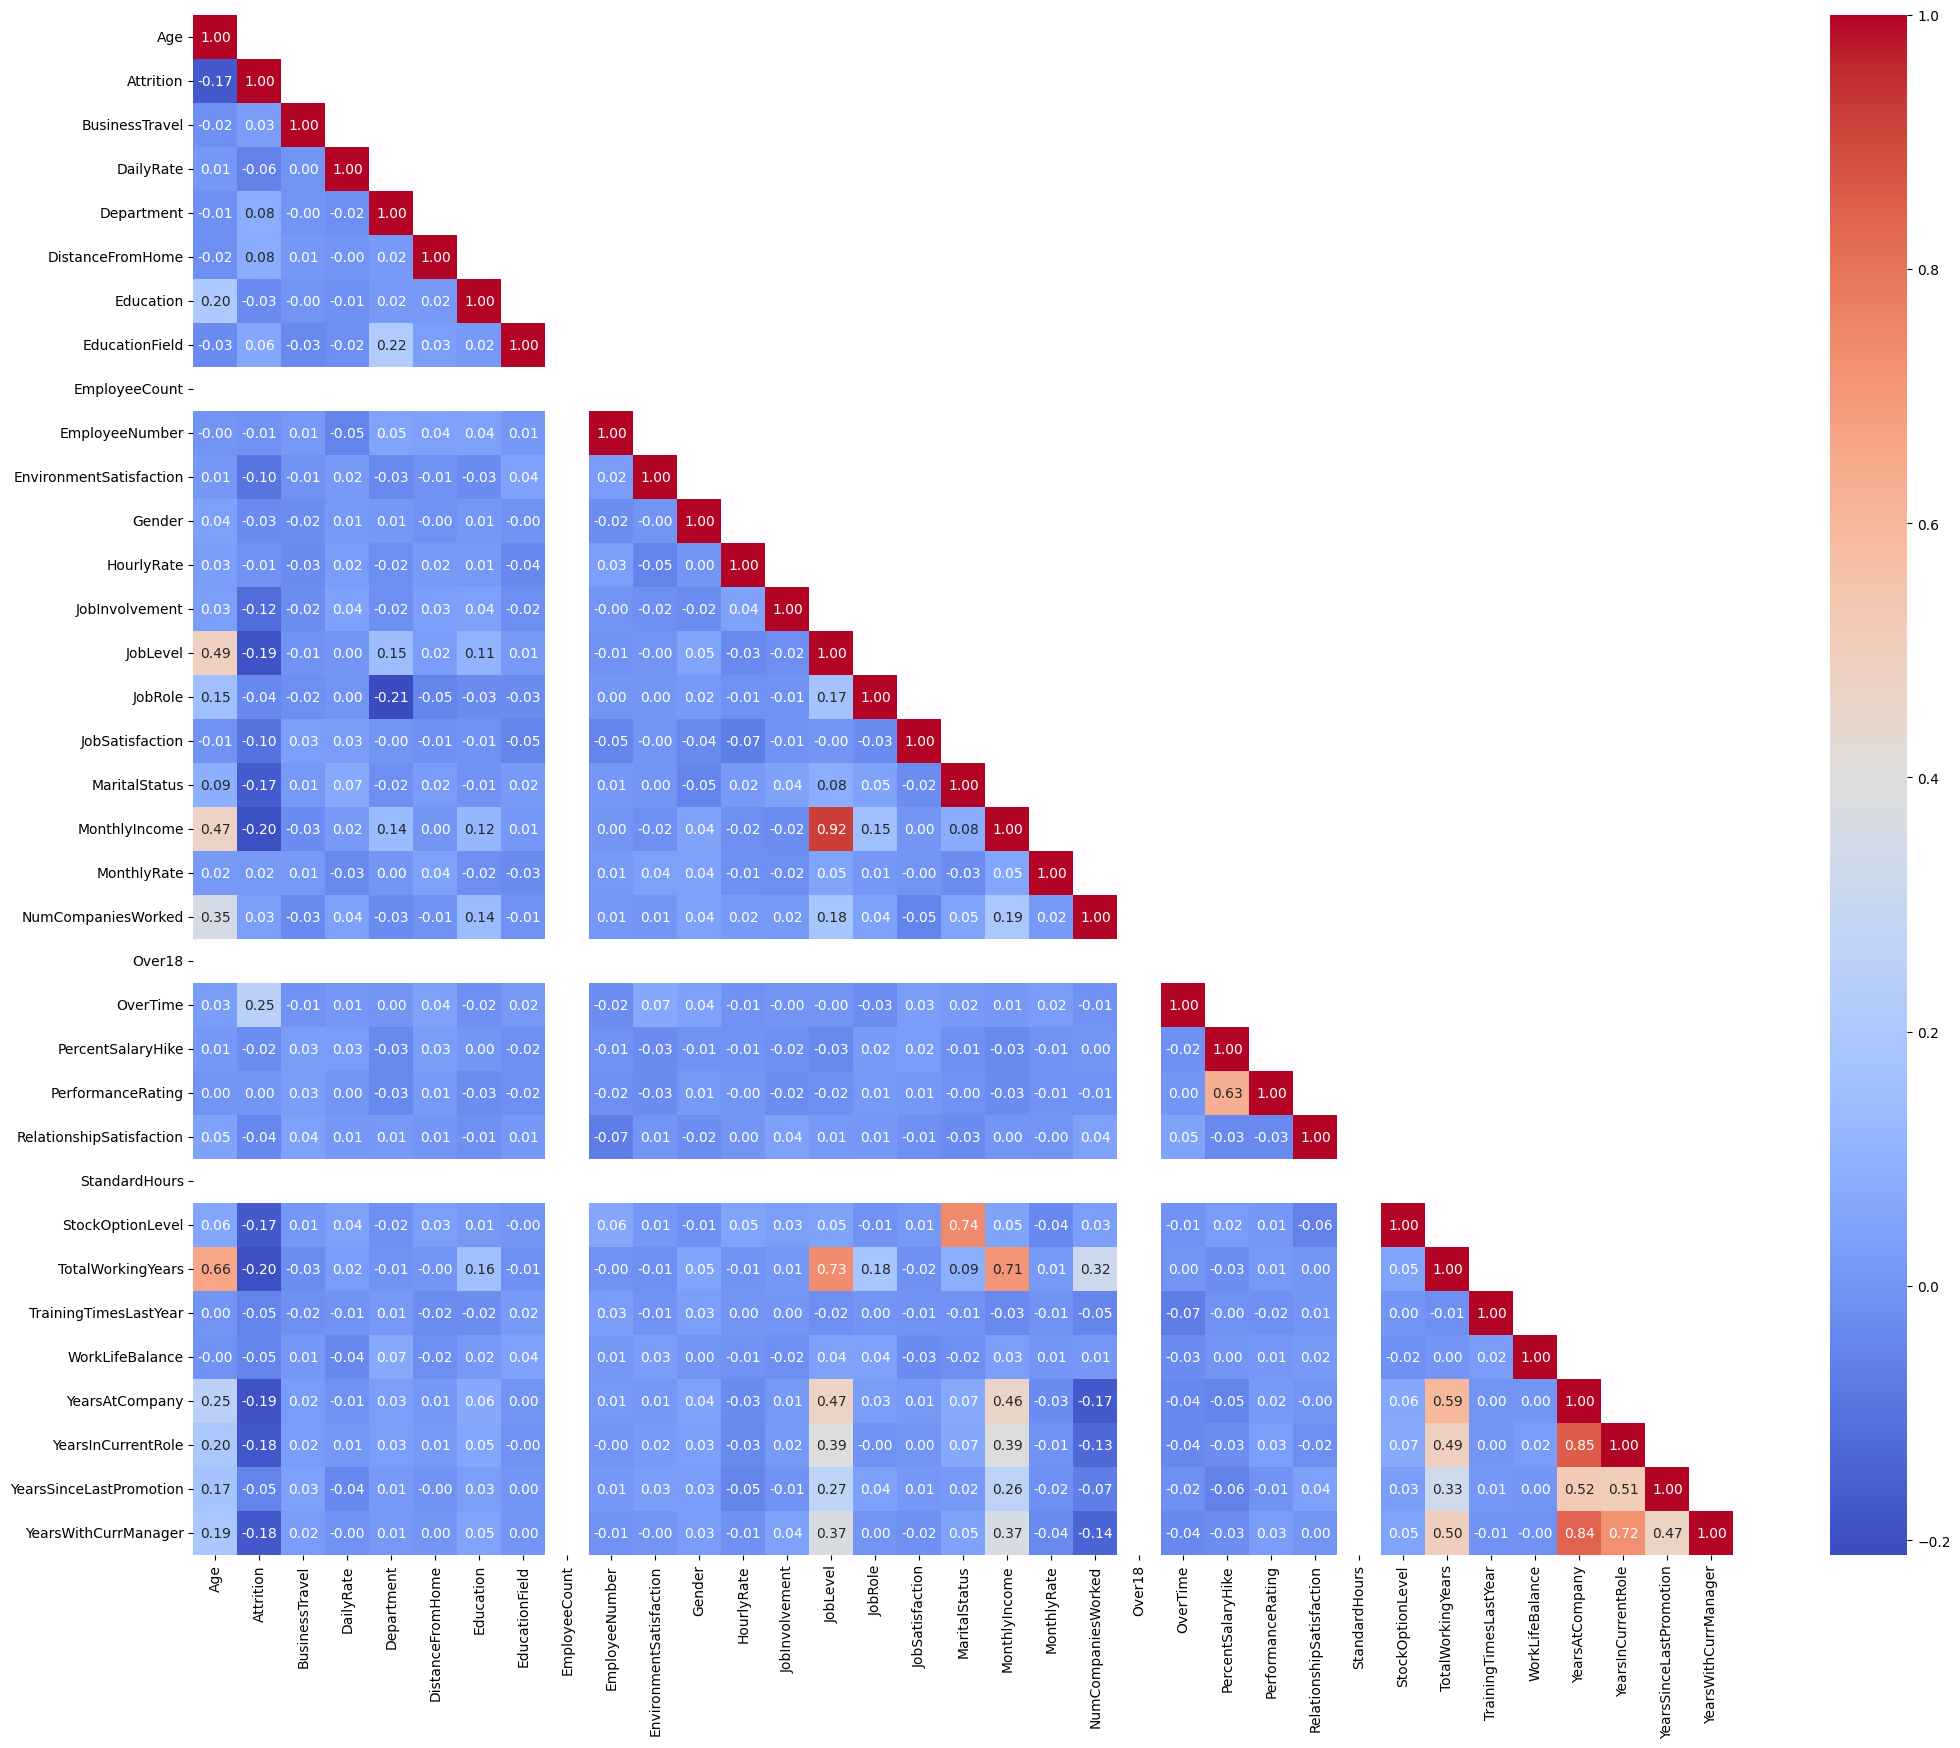

In [12]:
correlation(df)

Vamos a sacar las columnas que tiene valores irrelevantes o únicos

In [13]:
columns_to_drop = ['EmployeeCount', 'Over18', 'StandardHours', 'EmployeeNumber']

In [14]:
df.drop(columns_to_drop, axis=1, inplace=True)

### Kaplan-Meier

El método de Kaplan-Meier es una técnica estadística no paramétrica utilizada para estimar la función de supervivencia a partir de datos de tiempo de supervivencia. 

Por ejemplo, en el contexto de la investigación médica, el tiempo de supervivencia se refiere al tiempo que pasa desde un punto de inicio específico (como el diagnóstico de una enfermedad o el inicio del tratamiento) hasta un evento de interés (generalmente, la muerte o la recaída de la enfermedad).

Este estimador calcula la probabilidad de supervivencia en cada punto temporal donde ocurre un evento. A diferencia de otros métodos, el estimador de Kaplan-Meier puede manejar la censura de datos de forma adecuada, lo que lo hace muy útil en estudios clínicos y de investigación.

Aplicaciones:

* Investigación Médica: Muy utilizado para analizar la efectividad de nuevos tratamientos o medicamentos.
* Análisis de Fiabilidad: En ingeniería, para estudiar la vida útil de productos o componentes.
* Estudios Sociales: Como en la demografía para estudiar eventos como el matrimonio o el divorcio.

Ventajas:

* Puede manejar la censura de datos de manera efectiva.
* No requiere suposiciones sobre la forma de la función de supervivencia.
* Es útil para comparar la supervivencia entre diferentes grupos.

Limitaciones:
* No es adecuado cuando las tasas de riesgo de los sujetos cambian significativamente en el tiempo.
* No puede ajustarse por efectos de variables correlacionadas sin técnicas adicionales como el modelo de riesgos proporcionales de Cox.

Veamos la estimación de Kaplan-Meier para la deserción de los empleados:

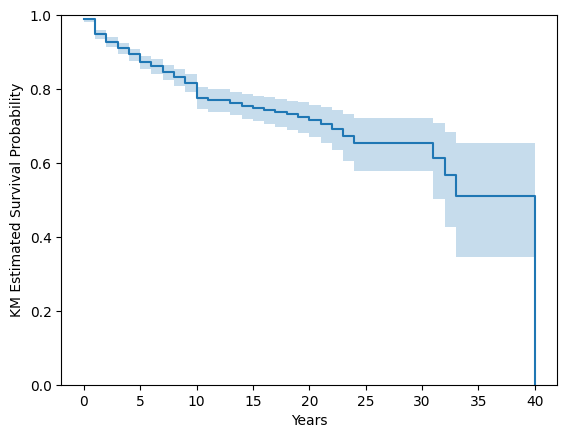

In [15]:
time, survival_prob, conf_int = kaplan_meier_estimator(
    df["Attrition"], df["YearsAtCompany"], conf_type="log-log"
)
plt.step(time, survival_prob, where="post")
plt.fill_between(time, conf_int[0], conf_int[1], alpha=0.25, step="post")
plt.ylim(0, 1)
plt.ylabel("KM Estimated Survival Probability")
plt.xlabel("Years")
plt.show()

Vamos a estratificar las estimaciónes de KM por diferentes características para ver el impacto de cada una.

La preguntas obvia que hay que hacerse es: ¿Hay alguna diferencia en la supervivencia entre diferentes características?

Veamos el caso del género:

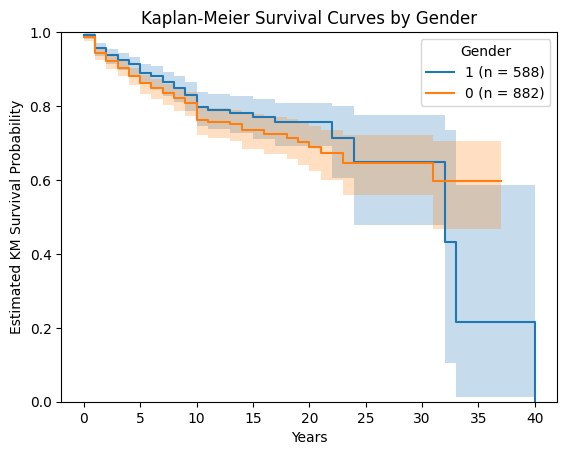

In [16]:
plot_kaplan_meier_curves(df, "Gender", "Attrition", "YearsAtCompany")

Los resultados no son concluyentes, porque la diferencia entre las dos funciones de supervivencia estimadas es pequeña para afirmar con seguridad que el género afecta o no a la supervivencia.

Veamos qué sucede con el departamento al cual pertenecen los empleados:

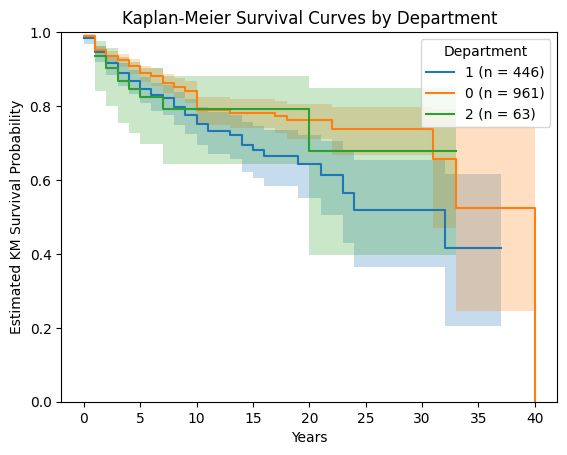

In [17]:
plot_kaplan_meier_curves(df, "Department", "Attrition", "YearsAtCompany")

Tampoco podemos observar diferencias sustanciales.

Veamos qué sucede con la educación que tiene cada empleado:

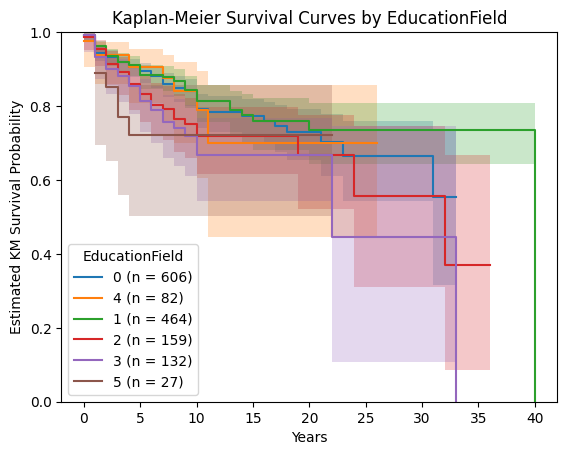

In [18]:
plot_kaplan_meier_curves(df, "EducationField", "Attrition", "YearsAtCompany")

Tampoco hay grandes discrepancias.

Veamos qué sucede con al fercuencia de viajes que tiene cada empleado:

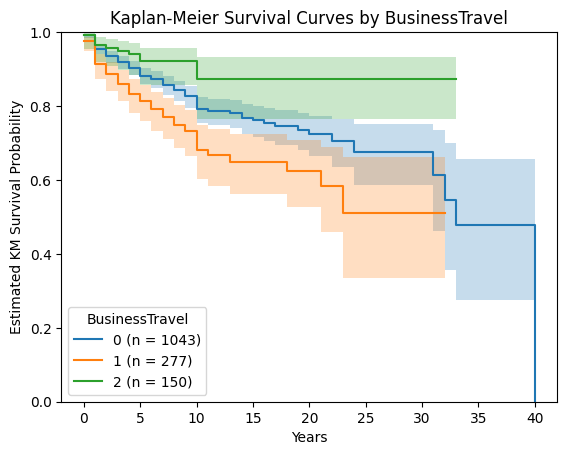

In [19]:
plot_kaplan_meier_curves(df, "BusinessTravel", "Attrition", "YearsAtCompany")

Aqui hay diferencias sustanciales. ('Travel_Rarely': 1, 'Travel_Frequently': 2, 'Non-Travel': 0)

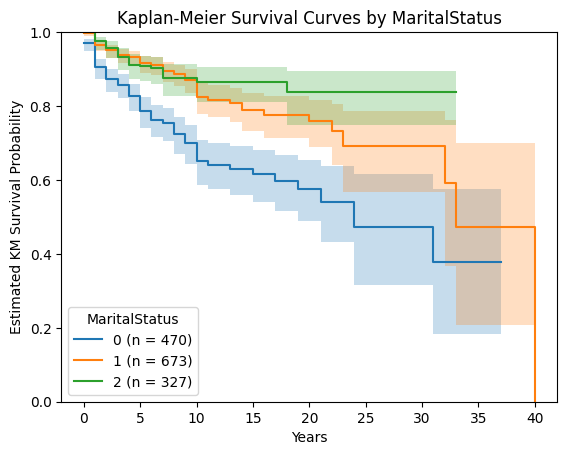

In [20]:
plot_kaplan_meier_curves(df, "MaritalStatus", "Attrition", "YearsAtCompany")

Aqui hay diferencias sustanciales.('Single': 0, 'Married': 1, 'Divorced': 2)

### Modelo de riesgos proporcionales de COX

En el enfoque de Kaplan-Meier utilizado anteriormente, estimamos múltiples curvas de supervivencia dividiendo el conjunto de datos en subgrupos más pequeños en función de una variable. 

Si queremos considerar más de 1 ó 2 variables, este enfoque se vuelve rápidamente inviable, porque los subgrupos serán muy pequeños. 

En su lugar, podemos utilizar un modelo lineal, el modelo de riesgos proporcionales de Cox, para estimar el impacto que tiene cada variable en la supervivencia.

El modelo de riesgos proporcionales de Cox, comúnmente conocido como el modelo de Cox, es una técnica estadística ampliamente utilizada en el análisis de supervivencia. Desarrollado por Sir David Cox en 1972, este modelo se utiliza para explorar la relación entre la supervivencia de un sujeto y una o más variables predictoras.

Principales Características del Modelo de Cox:

* Modelo Semiparamétrico: A diferencia de los modelos paramétricos, el modelo de Cox no asume una forma específica para la función de supervivencia. Esto lo hace particularmente flexible y útil en diversas situaciones.

* Riesgos Proporcionales: El modelo se basa en la hipótesis de riesgos proporcionales, que implica que los efectos de las variables predictoras son multiplicativos y constantes en el tiempo. En otras palabras, se asume que las variables predictoras afectan el riesgo de un evento de manera proporcional.

* Análisis Multivariable: Permite la inclusión de varias variables predictoras (tanto continuas como categóricas) en el análisis, lo que ayuda a entender cómo cada una afecta independientemente el tiempo hasta el evento, ajustando por las otras variables.

* Función de Riesgo: El modelo proporciona una función de riesgo que describe cómo el riesgo de evento (como la muerte o la falla) en un momento dado está relacionado con las variables predictoras.

Aplicaciones del Modelo de Cox:

* Investigación Médica: Para investigar los factores de riesgo asociados con eventos como enfermedades, muerte o recaída.

* Epidemiología: En el estudio de la incidencia y los factores de riesgo de enfermedades en diferentes poblaciones.

* Ingeniería de Fiabilidad: Para analizar la vida útil de los productos y la identificación de los factores que afectan a la falla de los componentes.

Ventajas del Modelo de Cox:

* Flexibilidad: Al no requerir una función de supervivencia específica, puede aplicarse en una amplia gama de contextos.dfbffllllsd,al
* Manejo de la Censura: Capaz de manejar datos censurados (cuando no se observa el evento para algunos sujetos durante el período de estudio).
* Interpretación de los Coeficientes: Los coeficientes del modelo representan el efecto logarítmico del riesgo relativo, lo que facilita la interpretación.

Limitaciones:

* Suposición de Riesgos Proporcionales: Si esta suposición no se cumple, las conclusiones del modelo pueden ser erróneas.
* Interacción y Variables Correlacionadas: Se requiere un análisis cuidadoso para interpretar correctamente las interacciones entre variables y el efecto de posibles variables correlacionadas.

Vamos a separar las caracteristicas de manera conveniente:

In [21]:
features =['Age', 'BusinessTravel', 'DailyRate', 'Department',
       'DistanceFromHome', 'Education', 'EducationField',
       'EnvironmentSatisfaction', 'Gender', 'HourlyRate',
       'JobInvolvement', 'JobLevel', 'JobRole', 'JobSatisfaction',
       'MaritalStatus', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked',
       'OverTime', 'PercentSalaryHike', 'PerformanceRating',
       'RelationshipSatisfaction','StockOptionLevel',
       'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance',
       'YearsInCurrentRole', 'YearsSinceLastPromotion',
       'YearsWithCurrManager', 'YearsAtCompany', 'Attrition']

In [22]:
time_column = 'YearsAtCompany'
event_column = 'Attrition'

Separamos los datos en train y test:

In [23]:
indices = np.random.choice(df.shape[0], df.shape[0], replace=False).tolist()

In [24]:
index_train, index_test = train_test_split(indices, test_size = 0.2)
df_train = df.loc[index_train].reset_index(drop = True)
df_test  = df.loc[index_test].reset_index(drop = True)

In [25]:
X_train, X_test = df_train[features], df_test[features]
T_train, T_test = df_train[time_column], df_test[time_column]
E_train, E_test = df_train[event_column], df_test[event_column]

In [26]:
y_train = np.array(list(zip(E_train.to_numpy(), T_train.to_numpy())), dtype='bool,i')

In [27]:
cox = CoxPHSurvivalAnalysis(alpha=1, n_iter=1000, ties='breslow', verbose=1)
cox.fit(X_train, y_train)

iter     10: optimization converged


/home/pdconte/Desktop/Colegio_Bourbaki/.venv/lib/python3.11/site-packages/sksurv/linear_model/coxph.py:83: RuntimeWarning: overflow encountered in exp
  self.baseline_survival_ = StepFunction(uniq_times, np.exp(-y))


CoxPHSurvivalAnalysis(alpha=1, n_iter=1000, verbose=1)

In [28]:
cox.score(X_train, y_train)

1.0

Testeamos la función de Cox:

In [29]:
y_test=np.array(list(zip(E_test.to_numpy(), T_test.to_numpy())), dtype='bool,i')

In [30]:
cox.score(X_test, y_test)

1.0

Hacemos la predicciones:

In [31]:
cox_predictions = cox.predict(X_test)

In [32]:
cox_predictions

array([-5.38179226e+01, -4.59588007e+01, -1.02289730e+01, -1.25968736e+02,
       -1.93504589e+01, -8.42844452e+01, -8.03679101e+01, -4.61278989e+01,
       -7.91435530e+00,  1.22500149e+00, -1.55731504e+01, -4.13753789e+00,
        5.06451681e+00, -1.92031899e+01, -1.15242746e+01, -6.38726520e+00,
       -2.69943034e+01, -2.70210562e+01, -7.27817260e+01, -1.93432607e+01,
       -2.71156821e+01, -8.03106233e+01, -2.69922017e+01, -7.67720658e+01,
       -8.41747922e+01, -7.84827884e+00, -7.83438400e+00, -3.83430438e+01,
       -3.99709477e+00, -1.91964819e+01,  5.06681135e+00, -3.48105510e+01,
       -2.32554062e+01, -1.16311895e+01, -6.36133499e+00, -1.39941176e+01,
       -1.54120286e+01, -1.17474870e+01, -3.33033196e+01, -4.23544794e+01,
       -1.93408814e+01, -3.96391913e+00, -3.84033161e+01, -7.86702553e+00,
       -8.02077432e+01, -8.66353087e+01, -4.21395699e+01, -6.90634560e+01,
       -3.84613435e+01, -3.08290985e+01, -3.32975871e+01, -3.46210170e+01,
       -3.84020856e+01, -

En el contexto de la clase CoxPHSurvivalAnalysis de la biblioteca scikit-survival, las predicciones del modelo suelen proporcionar las puntuaciones de riesgo de los individuos. Estas puntuaciones de riesgo son proporcionales a las tasas de riesgo y se basan en los predictores lineales del modelo, que a menudo son las log-razones de riesgo.

Para interpretar estas predicciones, siga estos pasos:

1. Comprender las puntuaciones de riesgo:
* Puntuaciones positivas: Una puntuación más alta indica un mayor riesgo de sufrir el suceso.
* Puntuación negativa: Una puntuación más baja (o negativa) indica un menor riesgo de experimentar el suceso.

2. Conversión a cocientes de riesgo:

Puede exponenciar estas puntuaciones para obtener cocientes de riesgo, lo que facilita su interpretación:

In [33]:
hazard_ratios = np.exp(cox_predictions)

In [34]:
hazard_ratios

array([4.23811942e-24, 1.09735332e-20, 3.61088346e-05, 1.96097922e-55,
       3.94641249e-09, 2.48731368e-37, 1.24928092e-35, 9.26633628e-21,
       3.65459422e-04, 3.40417117e+00, 1.72451393e-07, 1.59621037e-02,
       1.58303933e+02, 4.57257230e-09, 9.88715014e-06, 1.68285218e-03,
       1.89026628e-12, 1.84036690e-12, 2.46205656e-32, 3.97492191e-09,
       1.67420600e-12, 1.32293793e-35, 1.89424317e-12, 4.55318671e-34,
       2.77557043e-37, 3.90423373e-04, 3.95886105e-04, 2.22755104e-17,
       1.83689274e-02, 4.60334837e-09, 1.58667584e+02, 7.62025983e-16,
       7.94887069e-11, 8.88461475e-06, 1.72705957e-03, 8.36434529e-07,
       2.02600729e-07, 7.90917534e-06, 3.43994938e-15, 4.03351155e-19,
       3.98439064e-09, 1.89885497e-02, 2.09725739e-17, 3.83172402e-04,
       1.46628952e-35, 2.37008268e-38, 5.00054473e-19, 1.01419667e-30,
       1.97902256e-17, 4.08406485e-14, 3.45972579e-15, 9.21050328e-16,
       2.09983973e-17, 4.20308136e-09, 8.06487077e-06, 8.32882042e-07,
      

Un cociente de riesgos mayor que 1 indica un riesgo mayor, mientras que un cociente de riesgos menor que 1 indica un riesgo menor en comparación con el valor de referencia.

3. Estimación de la probabilidad de supervivencia:

Para estimar las probabilidades de supervivencia, necesitará combinar el modelo de Cox con una función de supervivencia de referencia. El CoxPHSurvivalAnalysis no proporciona directamente tiempos o probabilidades de supervivencia. Estima la función de riesgo.

Para obtener las probabilidades de supervivencia, puede utilizar el método predict_survival_function, que proporciona la función de supervivencia para cada individuo del conjunto de datos a lo largo del tiempo.

In [35]:
cox_survival = cox.predict_survival_function(X_test)

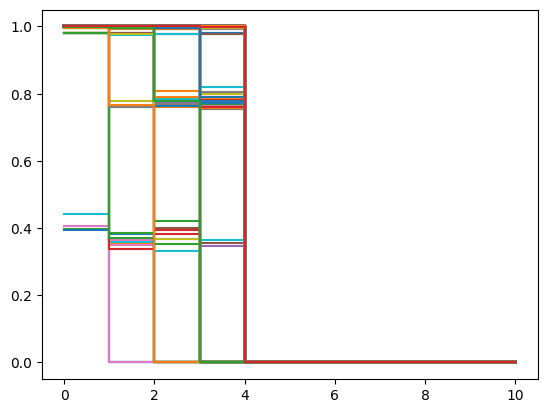

In [36]:
for fn in cox_survival:
    plt.step(fn.x, fn(fn.x), where="post")

plt.show()  

ValueError: x and y must have same first dimension, but have shapes (37,) and (1,)

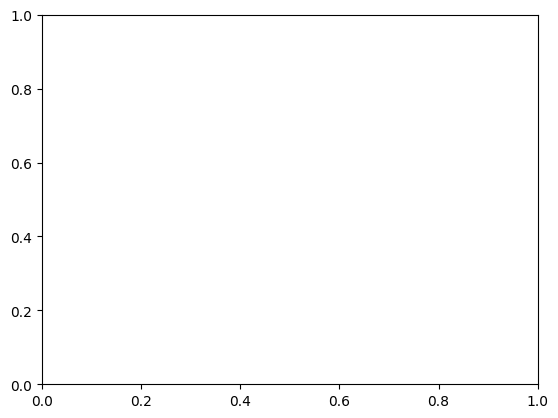

In [37]:
for i, s in enumerate(cox_survival):
    plt.step(cox.unique_times_, s, where="post", label=f"Subject {i}")

plt.ylabel("Survival Probability")
plt.xlabel("Time")
plt.show()

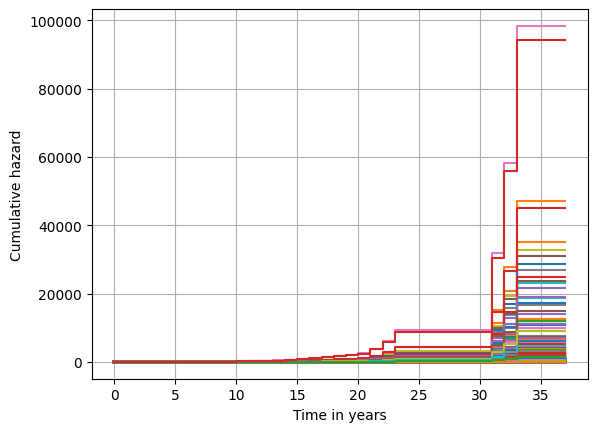

In [ ]:
cox_haz = cox.predict_cumulative_hazard_function(X_test, return_array=True)

for i, h in enumerate(cox_haz):
    plt.step(cox.unique_times_, h, where="post", label=str(i))
plt.ylabel("Cumulative hazard")
plt.xlabel("Time in years")
plt.grid(True)

In [ ]:
df_train

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,...,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,45,False,0,1005,0,28,2,3,4,1,...,3,3,0,21,2,3,21,6,8,6
1,39,False,1,672,0,7,2,1,3,0,...,3,1,1,21,2,3,21,9,13,3
2,55,False,0,1441,0,22,3,3,1,0,...,3,4,1,8,1,3,4,2,1,2
3,26,False,0,157,0,1,3,1,3,0,...,3,4,0,8,6,2,7,7,7,6
4,46,False,0,1450,0,15,2,0,4,0,...,3,1,1,25,2,3,4,2,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1171,44,False,0,625,0,4,3,1,4,0,...,3,4,0,10,2,2,5,2,2,3
1172,41,False,2,267,1,10,2,0,4,0,...,3,4,0,16,3,3,14,3,1,10
1173,21,False,0,391,0,15,2,0,3,0,...,3,4,0,0,6,3,0,0,0,0
1174,39,False,0,1387,0,10,5,1,2,0,...,3,4,3,10,3,3,7,7,7,7


In [ ]:
from lifelines import CoxPHFitter
from lifelines.statistics import proportional_hazard_test

cph = CoxPHFitter()
cph.fit(df_train, 'YearsAtCompany', 'Attrition')
test_results = proportional_hazard_test(cph, df_train, time_transform='rank')
test_results.print_summary()

<lifelines.StatisticalResult: proportional_hazard_test>
    time_transform = rank
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 1176 total observations, 989 right-censored observations>
         test_name = proportional_hazard_test

---
                          test_statistic      p  -log2(p)
Age                                 1.29   0.26      1.97
BusinessTravel                      4.52   0.03      4.90
DailyRate                           3.60   0.06      4.11
Department                          0.83   0.36      1.46
DistanceFromHome                    0.51   0.48      1.07
Education                           0.55   0.46      1.12
EducationField                      1.50   0.22      2.18
EnvironmentSatisfaction             2.16   0.14      2.82
Gender                              0.85   0.36      1.49
HourlyRate                          0.05   0.82      0.28
JobInvolvement                      0.01   0.93      0.11
JobLevel                            4.43   0.04      4.82
JobRole                             4.48   0.03      4.86
JobSatisfaction                     1.98   0.16      2.65
MaritalStatus                       0.26   0.61      0.71
MonthlyIncome                       4.45   0.03      4.84
MonthlyRate                         0.74   0.39      1.36
NumCompaniesWorked                  3.66   0.06      4.17
OverTime                            1.04   0.31      1.70
PercentSalaryHike                   0.42   0.52      0.95
PerformanceRating                   0.20   0.65      0.62
RelationshipSatisfaction            0.10   0.76      0.40
StockOptionLevel                    0.04   0.84      0.25
TotalWorkingYears                   8.90 <0.005      8.45
TrainingTimesLastYear               0.00   0.98      0.03
WorkLifeBalance                     0.55   0.46      1.12
YearsInCurrentRole                 61.80 <0.005     47.90
YearsSinceLastPromotion             0.04   0.84      0.25
YearsWithCurrManager               52.45 <0.005     41.04

In [ ]:
cph.concordance_index_

0.9462520248003128

<Axes: >

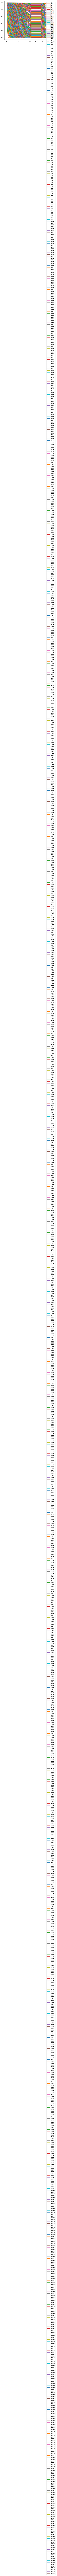

In [ ]:
cph.predict_survival_function(df_train).plot()

#### Seleccción de características

El modelo anterior tenía en cuenta todas las variables disponibles para la predicción. A continuación, queremos investigar qué variable individual es la que mejor predice el riesgo. 

Por lo tanto, ajustamos un modelo de Cox a cada variable individualmente y registramos el índice c en el conjunto de entrenamiento.

In [ ]:
def fit_and_score_features(X, y):
    n_features = X.shape[1]
    scores = np.empty(n_features)
    m = CoxPHSurvivalAnalysis()
    for j in range(n_features):
        Xj = X[:, j : j + 1]
        m.fit(Xj, y)
        scores[j] = m.score(Xj, y)
    return scores

In [ ]:
scores = fit_and_score_features(X_train.to_numpy(), y_train)

In [ ]:
pd.Series(scores, index=X_train.columns).sort_values(ascending=False)

YearsInCurrentRole                   0.859568
YearsWithCurrManager                 0.851535
TotalWorkingYears                    0.827857
MonthlyIncome                        0.777820
JobLevel                             0.748702
Age                                  0.707420
YearsSinceLastPromotion              0.659542
OverTime_No                          0.638118
OverTime_Yes                         0.638118
MaritalStatus_Single                 0.620553
StockOptionLevel                     0.620038
JobSatisfaction                      0.585847
JobRole_Laboratory Technician        0.583823
JobRole_Sales Representative         0.577691
JobInvolvement                       0.572925
MaritalStatus_Married                0.569369
Education                            0.566244
DistanceFromHome                     0.554877
MaritalStatus_Divorced               0.551184
DailyRate                            0.547744
BusinessTravel_Travel_Frequently     0.547335
JobRole_Healthcare Representative 

#### Grid Search

A continuación, queremos construir un modelo parsimonioso excluyendo las características irrelevantes. Podríamos utilizar la clasificación anterior, pero tendríamos que determinar cuál debería ser el límite óptimo. 

Por suerte, scikit-learn tiene soporte incorporado para realizar Grid Search.

En primer lugar, creamos un pipeline que pone todas las partes juntas.

In [ ]:
pipe = Pipeline(
    [
        ("select", SelectKBest(fit_and_score_features, k=3)),
        ("model", CoxPHSurvivalAnalysis()),
    ]
)

A continuación, tenemos que definir el rango de parámetros que queremos explorar durante la búsqueda en la cuadrícula. 

En este caso, queremos optimizar el parámetro k de la clase SelectKBest y permitir que k varíe entre 1 característica y las 29 características.

In [ ]:
param_grid = {"select__k": np.arange(1, X_train.to_numpy().shape[1] + 1)}
cv = KFold(n_splits=3, random_state=1, shuffle=True)
gcv = GridSearchCV(pipe, param_grid, return_train_score=True, cv=cv)
gcv.fit(X_train.to_numpy(), y_train)

GridSearchCV(cv=KFold(n_splits=3, random_state=1, shuffle=True),
             estimator=Pipeline(steps=[('select',
                                        SelectKBest(k=3,
                                                    score_func=<function fit_and_score_features at 0x7f2032c0e700>)),
                                       ('model', CoxPHSurvivalAnalysis())]),
             param_grid={'select__k': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29])},
             return_train_score=True)

In [ ]:
results = pd.DataFrame(gcv.cv_results_).sort_values(by="mean_test_score", ascending=False)
results.loc[:, ~results.columns.str.endswith("_time")]

,param_select__k,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
23,24,{'select__k': 24},0.946975,0.910533,0.937255,0.931588,0.015408,1,0.943906,0.949962,0.933486,0.942452,0.006805
28,29,{'select__k': 29},0.943050,0.912392,0.938833,0.931425,0.013568,2,0.944667,0.951740,0.934288,0.943565,0.007167
22,23,{'select__k': 23},0.945123,0.910915,0.938190,0.931410,0.014765,3,0.943991,0.950387,0.934115,0.942831,0.006693
25,26,{'select__k': 26},0.944827,0.910915,0.937547,0.931097,0.014576,4,0.944188,0.950175,0.933361,0.942574,0.006958
24,25,{'select__k': 25},0.944827,0.910915,0.937431,0.931058,0.014559,5,0.944582,0.949995,0.933219,0.942599,0.006991
21,22,{'select__k': 22},0.945568,0.908619,0.936554,0.930247,0.015730,6,0.942878,0.950354,0.932008,0.941747,0.007532
27,28,{'select__k': 28},0.942753,0.910970,0.936613,0.930112,0.013766,7,0.944413,0.951218,0.933439,0.943024,0.007324
26,27,{'select__k': 27},0.943050,0.909001,0.937547,0.929866,0.014924,8,0.944371,0.950370,0.933266,0.942669,0.007086
19,20,{'select__k': 20},0.943124,0.908455,0.934393,0.928657,0.014723,9,0.940695,0.947483,0.928926,0.939035,0.007666
18,19,{'select__k': 19},0.942013,0.910423,0.933166,0.928534,0.013306,10,0.938752,0.945380,0.927417,0.937183,0.007417


El modelo de riesgos proporcionales de Cox es, con diferencia, el modelo de supervivencia más popular, ya que, una vez entrenado, es fácil de interpretar. Sin embargo, si el objetivo principal es el rendimiento de la predicción, los modelos más sofisticados, no lineales o de conjunto podrían dar mejores resultados.

**Modelos de Cox penalizados**

El modelo de riesgos proporcionales de Cox suele ser un modelo atractivo, porque sus coeficientes pueden interpretarse en términos de cociente de riesgos, lo que a menudo proporciona información valiosa. 

Sin embargo, si queremos estimar los coeficientes de muchas características, el modelo estándar de Cox se viene abajo, porque internamente intenta invertir una matriz que se vuelve no singular debido a las correlaciones entre las características.

Las penalizaciones existentes son:
* Ridge
* LASSO
* Elastic Net

Pueden investigar mas sobre ello aquí: https://scikit-survival.readthedocs.io/en/stable/user_guide/coxnet.html

### Random Survival Forest

Al igual que sus homólogos populares para la clasificación y la regresión, un Bosque de Supervivencia Aleatorio es un conjunto de aprendices basados en árboles. 

Un bosque de supervivencia aleatorio garantiza que los árboles individuales estén descorrelacionados mediante:
1) la construcción de cada árbol en una muestra bootstrap diferente de los datos de entrenamiento originales, y 

2) en cada nodo, sólo evalúa el criterio de división para un subconjunto de características y umbrales seleccionados aleatoriamente. 

Las predicciones se forman agregando las predicciones de los árboles individuales del conjunto.

El criterio más extendido se basa en la prueba log-rank, que probablemente conozca al comparar curvas de supervivencia entre dos o más grupos. 

Utilizando los datos de entrenamiento, ajustamos un Bosque de Supervivencia Aleatorio compuesto por 1000 árboles.

In [ ]:
rsf = RandomSurvivalForest(n_estimators=1000,
                           max_depth=10,
                           max_features="sqrt",
                           random_state=42,
                           n_jobs=4
                           )


In [ ]:
rsf.fit(X_train_encoded, y_train)

RandomSurvivalForest(max_depth=10, n_estimators=1000, n_jobs=4, random_state=42)

In [ ]:
rsf.score(X_train_encoded, y_train)

0.9746708623195564

In [ ]:
rsf.score(X_test_encoded, y_test)

0.892594510616261

In [ ]:
rsf_predictions=rsf.predict(X_test_encoded)

In [ ]:
rsf_predictions

array([11.02169269, 16.90621694,  5.88624384, 10.49606943,  4.55217607,
        6.12162308, 10.93598539,  4.54597597,  1.56726121,  7.20143337,
        5.66550676,  5.1741716 , 10.9470001 ,  8.03175181, 10.92623837,
       21.52226363,  5.39562373, 12.22604412, 17.46051978,  8.05383753,
       10.10479128,  5.81503308,  4.67433293,  2.56024723,  3.11494305,
       10.41064904,  5.47939388,  7.09533793,  5.6343153 , 15.11857646,
       12.49256989,  4.46121108,  6.69554711,  2.6389883 ,  4.01147295,
        2.17443351,  6.11250807,  4.91852789, 12.01693284,  6.74851302,
        6.58209376,  7.16249835,  9.25000331,  8.80959378,  4.64972296,
        9.82619375,  2.90916331,  2.77368911,  7.68275251,  6.59610072,
       11.17388733, 10.29087831,  6.75635349, 23.75590336,  7.3486004 ,
        4.76991195, 10.20254578,  4.53068013,  8.25929498,  5.92063391,
        5.88492952,  3.6637304 ,  3.07075902, 13.07738792, 16.07490061,
       12.14200728,  0.78151548,  3.57373066,  2.06327554,  3.31

In [ ]:
rsf_survival = rsf.predict_survival_function(X_test_encoded, return_array=True)

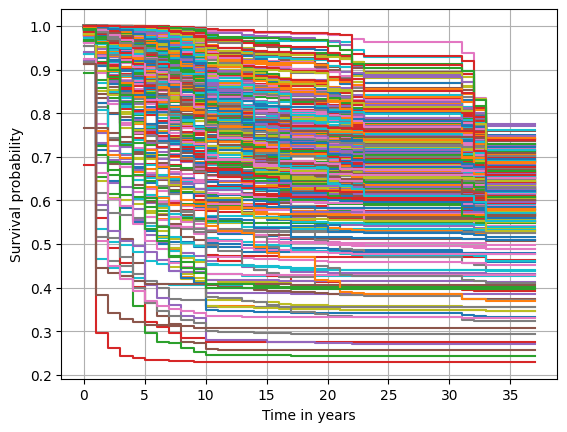

In [ ]:
for i, s in enumerate(rsf_survival):
    plt.step(rsf.unique_times_, s, where="post", label=str(i))
plt.ylabel("Survival probability")
plt.xlabel("Time in years")
plt.grid(True)

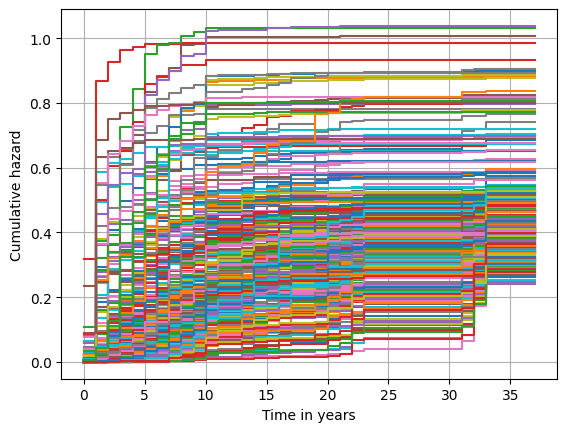

In [ ]:
rsf_haz = rsf.predict_cumulative_hazard_function(X_test_encoded, return_array=True)

for i, h in enumerate(rsf_haz):
    plt.step(rsf.unique_times_, h, where="post", label=str(i))
plt.ylabel("Cumulative hazard")
plt.xlabel("Time in years")
plt.grid(True)

#### Importancia de las características basada en permutaciones

La implementación se basa en la implementación de Random Forest de scikit-learn y hereda muchas características, como la construcción de árboles en paralelo. Lo que falta actualmente son importancias de características a través del atributo feature_importance_. 

Esto se debe a la forma en que la implementación de scikit-learn calcula las importancias. Se basa en una medida de impureza para cada nodo hijo, y define la importancia como la cantidad de disminución de la impureza debido a una división. Para la regresión tradicional, la impureza se mediría por la varianza, pero para el análisis de supervivencia no hay una medida de impureza por nodo debido a la censura. 

En su lugar, se podría utilizar la magnitud de la estadística de prueba log-rank como medida de importancia, pero la implementación de scikit-learn no parece permitirlo.

Afortunadamente, esto no es una gran preocupación, ya que la definición de scikit-learn de la importancia de la característica no es estándar y difiere de lo que Leo Breiman propuso en el documento original de Random Forest. En su lugar, podemos utilizar la permutación para estimar la importancia de las características, que es preferible a la definición de scikit-learn. 

Esto se implementa en la función permutation_importance de scikit-learn, que es totalmente compatible con scikit-survival.

In [ ]:
result = permutation_importance(rsf, X_test, y_test, n_repeats=20, random_state=42)

In [ ]:
pd.DataFrame(
    {
        k: result[k]
        for k in (
            "importances_mean",
            "importances_std",
        )
    },
    index=X_test.columns,
).sort_values(by="importances_mean", ascending=False)


,importances_mean,importances_std
OverTime,0.035760,0.010139
YearsWithCurrManager,0.023698,0.006032
YearsInCurrentRole,0.019610,0.007186
NumCompaniesWorked,0.011206,0.003973
StockOptionLevel,0.010481,0.004920
TotalWorkingYears,0.010433,0.003916
EnvironmentSatisfaction,0.009518,0.003163
MaritalStatus,0.005657,0.002487
JobLevel,0.004884,0.005527
DistanceFromHome,0.004471,0.002850


Ejercicios:

**Kaplan-Meier:**

* ¿Qué mide la curva de Kaplan-Meier y por qué es importante en el análisis de supervivencia?
* ¿Cómo maneja el método de Kaplan-Meier los datos censurados?
* Describe una situación en la que sería apropiado usar el estimador de Kaplan-Meier.

**Modelos de Cox:**

* ¿Qué hipótesis fundamental se establece en el modelo de riesgos proporcionales de Cox?
* Explica cómo se interpreta un coeficiente de riesgo (hazard ratio) en un modelo de Cox.
* ¿En qué se diferencia el modelo de Cox de los métodos de análisis de supervivencia más tradicionales?

**Random Survival Forest:**

* ¿Qué es un Random Survival Forest y cómo se relaciona con los métodos tradicionales de árboles de decisión?
* ¿Cómo maneja Random Survival Forest los datos censurados en el análisis de supervivencia?
* Describe una ventaja y una limitación de usar Random Survival Forest en comparación con el modelo de Kaplan-Meier o el modelo de Cox.

**Aplicación Práctica:**

* ¿Cómo determinarías qué método de análisis de supervivencia es el más adecuado para un conjunto específico de datos?
* Da un ejemplo de cómo los resultados de un modelo de Cox podrían ser utilizados en la toma de decisiones clínicas.
* ¿Cómo podrías evaluar la precisión de un modelo Random Survival Forest?

Referencias:

* Scikit-Survival: https://scikit-survival.readthedocs.io/en/stable/index.html
* PySurvival: https://square.github.io/pysurvival/
* Employee Retention: https://square.github.io/pysurvival/tutorials/employee_retention.html


![Colegio Bourbaki](./Images/Matematicas.png)

![Colegio Bourbaki](./Images/Contacto.png)